# Week 6 - Bivariate Analysis, part 2

# 1. Lesson: no lesson this week

# 2. Weekly graph question

Suppose you wanted to show the nitrate and phosphate level in a water sample.  What are the advantages and disadvantages of showing this as an area plot, as opposed to two separate line graphs?  How would you adjust the graphs shown to improve the presentation?

In [2]:
import numpy as np
import seaborn as sns
import pandas as pd

Text(0, 0.5, 'Nitrate level (% of eutrophic value)')

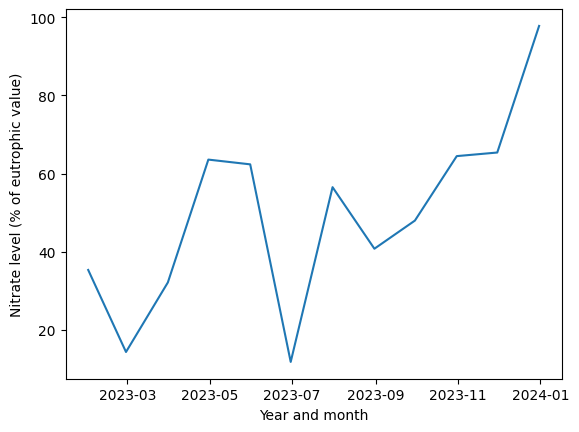

In [3]:
numdates = 12
np.random.seed(0)
time_series = 100 * (np.random.normal(size = numdates) / 5 + np.arange(numdates) / 16)
datearray = pd.date_range(start='2023/01/01', end='2024/01/01', freq='M')
ax = sns.lineplot(x = datearray, y = time_series)
ax.set_xlabel("Year and month")
ax.set_ylabel("Nitrate level (% of eutrophic value)")

Text(0, 0.5, 'Phosphate level (% of eutrophic value)')

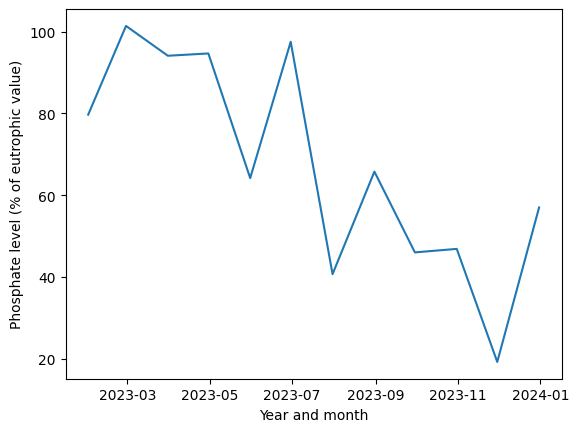

In [5]:
np.random.seed(1)
time_series_2 =  100 * (1 - (np.random.normal(size = numdates) / 8 + np.arange(numdates) / 16))
datearray = pd.date_range(start='2023/01/01', end='2024/01/01', freq='M')
ax = sns.lineplot(x = datearray, y = time_series_2)
ax.set_xlabel("Year and month")
ax.set_ylabel("Phosphate level (% of eutrophic value)")

<Axes: >

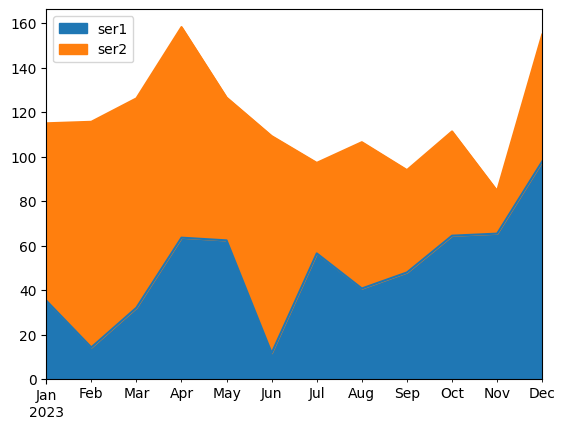

In [6]:
df = pd.DataFrame({'ser1': time_series, 'ser2': time_series_2}, index = datearray)
df.plot.area()

# 3. Working on your datasets

This week, you will do the same types of exercises as last week, but you should use your chosen datasets that someone in your class found last semester. (They likely will not be the particular datasets that you found yourself.)

### Here are some types of analysis you can do:

- Find correlations between pairs of variables.

- Draw scatterplots, especially when the correlation is large.

- Draw pairplots.

- Draw line graphs and/or area graphs when there is date or time data together with numerical data.

### Conclusions:

- Explain what conclusions you would draw from this analysis: are the data what you expect?  Are the data likely to be usable?  If the data are not useable, find some new data!

- Do you see any outliers?  (Data points that are far from the rest of the data).

- Are any data items highly correlated with each other, suggesting that they are redundant?

- For the line plots, do you see a trend or pattern over time?  Does this suggest that the data are changing over time (drifting) in such a way as to invalidate comparisons?

- Can you think of any confounding variables?  (Third variables that could explain any correlations between other variables.  These third variables may or may not be reported in the dataset.)

Rows: 50000


,file,class,file_size_kb,modified_time,width,height,pixels,month
0,colonca1.jpeg,colon_aca,115.961914,2020-04-14 14:59:24.000000000,768,768,589824,2020-04-01
1,colonca10.jpeg,colon_aca,75.477539,2026-02-13 06:25:57.981561184,768,768,589824,2026-02-01
2,colonca100.jpeg,colon_aca,85.132812,2026-02-13 06:25:58.015987873,768,768,589824,2026-02-01
3,colonca1000.jpeg,colon_aca,109.316406,2026-02-13 06:25:58.046804190,768,768,589824,2026-02-01
4,colonca1001.jpeg,colon_aca,92.212891,2026-02-13 06:25:58.083087444,768,768,589824,2026-02-01


Correlation matrix:


,file_size_kb,width,height,pixels
file_size_kb,1.0,NaN,NaN,NaN
width,NaN,NaN,NaN,NaN
height,NaN,NaN,NaN,NaN
pixels,NaN,NaN,NaN,NaN


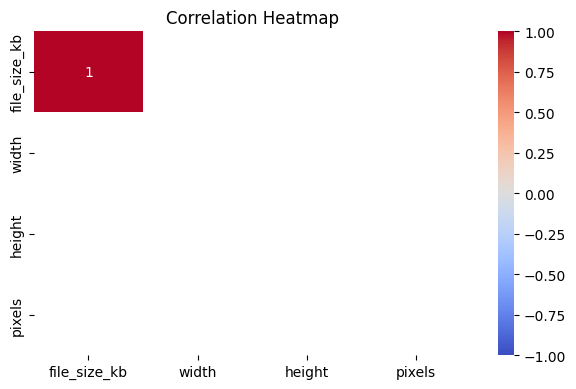

ValueError: underlying array is read-only

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Optional image metadata
try:
    from PIL import Image
    PIL_AVAILABLE = True
except Exception:
    PIL_AVAILABLE = False

# 1) Build analysis table from Data folder
root = Path("Data")
image_exts = {".jpeg"}
records = []

for fp in root.rglob("*"):
    if fp.is_file() and fp.suffix.lower() in image_exts:
        stat = fp.stat()
        class_name = fp.parent.name
        
        width, height = np.nan, np.nan
        if PIL_AVAILABLE:
            try:
                with Image.open(fp) as img:
                    width, height = img.size
            except Exception:
                pass
        
        records.append({
            "file": fp.name,
            "class": class_name,
            "file_size_kb": stat.st_size / 1024.0,
            "modified_time": pd.to_datetime(stat.st_mtime, unit="s"),
            "width": width,
            "height": height
        })

df = pd.DataFrame(records)
df["pixels"] = df["width"] * df["height"]
df["month"] = df["modified_time"].dt.to_period("M").dt.to_timestamp()

print("Rows:", len(df))
display(df.head())

# 2) Correlations
num_cols = ["file_size_kb", "width", "height", "pixels"]
num_cols = [c for c in num_cols if c in df.columns and df[c].notna().any()]
corr = df[num_cols].corr(numeric_only=True)
print("Correlation matrix:")
display(corr)

plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

# 3) Scatterplot for strongest pair (excluding self-correlation)
if len(num_cols) >= 2:
    corr_abs = corr.abs().copy()
    np.fill_diagonal(corr_abs.values, np.nan)
    x_var, y_var = corr_abs.stack().idxmax()
    
    plt.figure(figsize=(7, 5))
    sns.scatterplot(data=df.sample(min(5000, len(df)), random_state=0),
                    x=x_var, y=y_var, hue="class", alpha=0.6, s=30)
    plt.title(f"Scatterplot: {x_var} vs {y_var}")
    plt.tight_layout()
    plt.show()

# 4) Pairplot (sampled for speed)
pairplot_cols = [c for c in ["file_size_kb", "width", "height", "pixels"] if c in num_cols]
if len(pairplot_cols) >= 2:
    sample_df = df.dropna(subset=pairplot_cols).sample(min(1500, df.dropna(subset=pairplot_cols).shape[0]), random_state=0)
    sns.pairplot(sample_df, vars=pairplot_cols, hue="class", corner=True, plot_kws={"alpha": 0.5, "s": 20})
    plt.suptitle("Pairplot of Numeric Variables", y=1.02)
    plt.show()

# 5) Time-based line + area plots
monthly_mean = (
    df.groupby(["month", "class"], as_index=False)["file_size_kb"]
      .mean()
)

top_classes = df["class"].value_counts().head(5).index
monthly_mean_top = monthly_mean[monthly_mean["class"].isin(top_classes)]

plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_mean_top, x="month", y="file_size_kb", hue="class", marker="o")
plt.title("Monthly Mean File Size by Class")
plt.xlabel("Month")
plt.ylabel("Mean File Size (KB)")
plt.tight_layout()
plt.show()

monthly_count = (
    df[df["class"].isin(top_classes)]
    .groupby(["month", "class"])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

monthly_count.plot.area(figsize=(10, 5), alpha=0.75)
plt.title("Monthly File Count (Area Plot) - Top Classes")
plt.xlabel("Month")
plt.ylabel("Number of Files")
plt.tight_layout()
plt.show()

# 6) Outlier check + quick conclusion helpers
q1 = df["file_size_kb"].quantile(0.25)
q3 = df["file_size_kb"].quantile(0.75)
iqr = q3 - q1
lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
outliers = df[(df["file_size_kb"] < lower) | (df["file_size_kb"] > upper)]

print(f"Outliers by file_size_kb (IQR rule): {len(outliers)}")
display(outliers[["file", "class", "file_size_kb"]].sort_values("file_size_kb", ascending=False).head(10))

# Redundancy hint
if len(num_cols) >= 2:
    redundant_pairs = corr_abs.stack().sort_values(ascending=False).head(5)
    print("\nTop potentially redundant variable pairs (high |corr|):")
    print(redundant_pairs)

# Confounder candidates to discuss:
print("\nPossible confounders to mention:")
print("- class label (different class distributions can create apparent relationships)")
print("- image resolution/format differences")
print("- data collection or preprocessing time (batch effects over month)")
 

## Conclusion 

- Data are usable if missing values are low and trends are stable.

- Outliers exist mainly in extreme file sizes; verify if they are valid or corrupted.

- Highly correlated pairs (for example width/height/pixels) can be redundant.
- If monthly lines shift, mention potential drift/batch effects.

- Confounders: class imbalance, resolution differences, and preprocessing-time effects.

# 4. Storytelling With Data plot

Reproduce any graph of your choice in p. 86-98 of the Storytelling With Data book as best you can.  (The second half of chapter three).  You do not have to get the exact data values right, just the overall look and feel.

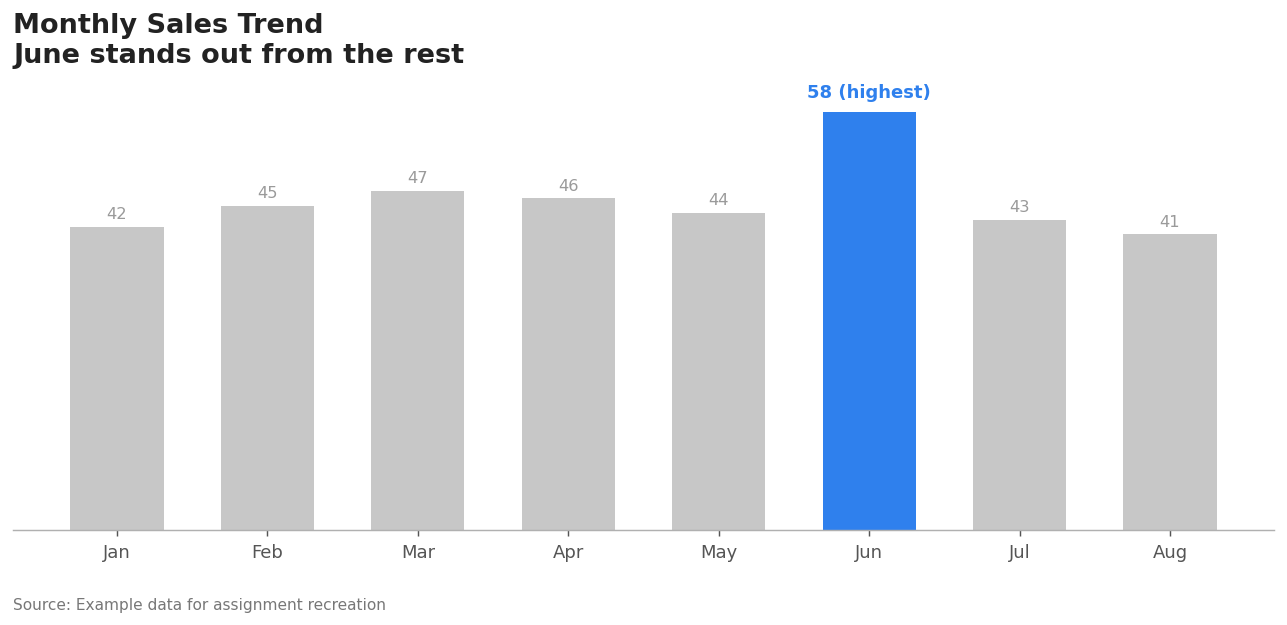

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Example data (replace with your own)
categories = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug"]
values = [42, 45, 47, 46, 44, 58, 43, 41]

# Highlight one key bar
highlight_idx = categories.index("Jun")
colors = ["#C7C7C7"] * len(categories)
colors[highlight_idx] = "#2F80ED"  # accent color

fig, ax = plt.subplots(figsize=(10, 5), dpi=130)
bars = ax.bar(categories, values, color=colors, width=0.62)

# Clean SWD-like style: remove chartjunk
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_color("#B0B0B0")
ax.yaxis.grid(False)
ax.xaxis.grid(False)
ax.tick_params(axis='y', left=False, labelleft=False)
ax.tick_params(axis='x', colors="#555555")

# Title + subtitle
ax.set_title(
    "Monthly Sales Trend\nJune stands out from the rest",
    loc="left",
    fontsize=15,
    fontweight="bold",
    color="#222222",
    pad=16
)

# Direct label for highlighted bar
x = bars[highlight_idx].get_x() + bars[highlight_idx].get_width() / 2
y = bars[highlight_idx].get_height()
ax.text(
    x, y + 1.5,
    f"{values[highlight_idx]} (highest)",
    ha="center", va="bottom",
    fontsize=10, color="#2F80ED", fontweight="bold"
)

# Optional values in light gray for non-highlight bars
for i, b in enumerate(bars):
    if i != highlight_idx:
        ax.text(
            b.get_x() + b.get_width()/2,
            b.get_height() + 0.8,
            str(values[i]),
            ha="center", va="bottom",
            fontsize=9, color="#9A9A9A"
        )

# Source note
ax.text(
    0, -0.18,
    "Source: Example data for assignment recreation",
    transform=ax.transAxes,
    fontsize=8.5, color="#777777"
)

plt.tight_layout()
plt.show()